# Lab-10 Practice on Autoregression

### Import the required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from statsmodels.tsa.ar_model import AutoReg as AR
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


/home/sujeet/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/sujeet/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Plotting the the time series data

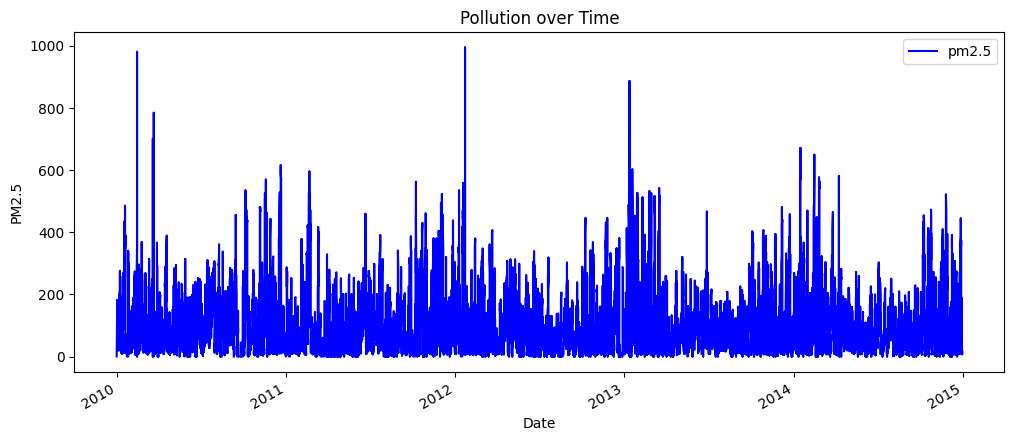

In [2]:
################ Plotting Data #####################
# Load dataset
df = pd.read_csv("Pollution.csv", parse_dates=["Date"], index_col="Date")

# 1(a): Line plot of Pollution
df.plot(y="pm2.5", title="Pollution over Time", figsize=(12,5), color='blue')
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.show()


### Auto-correlation for lag=1

            pm2.5  lag_1
Date                    
2010-01-01      0    NaN
2010-01-01      0    0.0
2010-01-01      0    0.0
2010-01-01      0    0.0
2010-01-01      0    0.0
...           ...    ...
2014-12-31      8   10.0
2014-12-31     10    8.0
2014-12-31     10   10.0
2014-12-31      8   10.0
2014-12-31     12    8.0

[43824 rows x 2 columns]
Pearson correlation for one-day lag: 0.9554


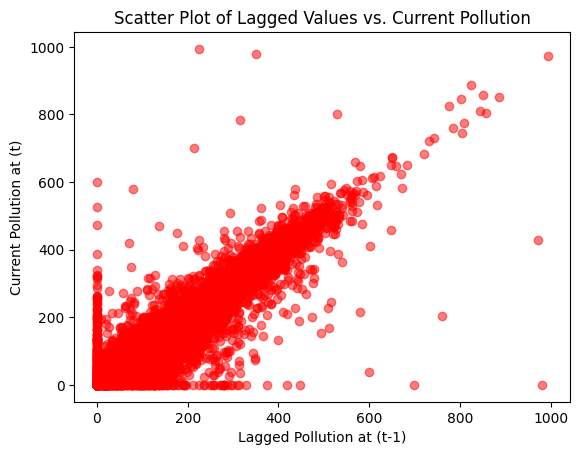

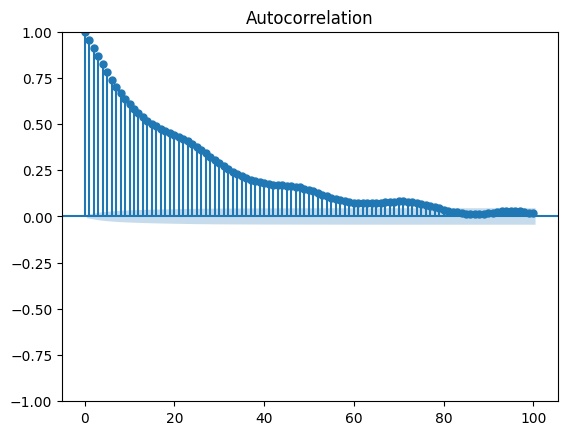

In [3]:
# Compute one-day lag data column
df["lag_1"] = df["pm2.5"].shift(1)

print(df)
# Compute correlation with one-day lag values
correlation, _ = pearsonr(df.dropna()["pm2.5"], df.dropna()["lag_1"])
print(f"Pearson correlation for one-day lag: {correlation:.4f}")

# Scatter plot for one-day lag correlation
plt.scatter(df["lag_1"], df["pm2.5"], alpha=0.5, color='red')
plt.xlabel("Lagged Pollution at (t-1)")
plt.ylabel("Current Pollution at (t)")
plt.title("Scatter Plot of Lagged Values vs. Current Pollution")
plt.show()

# ACF plot
plot_acf(df.dropna()["pm2.5"], lags=100)
plt.show()

### Autoregression for lag=5

/home/sujeet/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/tmp/ipykernel_7803/1282603950.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat = coef[0] + sum(coef[i+1] * lag_values[lag-i-1] for i in range(lag))


AR(5) Model Coefficients: const       4.712270
pm2.5.L1    0.943000
pm2.5.L2    0.029671
pm2.5.L3   -0.011577
pm2.5.L4   -0.003821
pm2.5.L5   -0.006826
dtype: float64


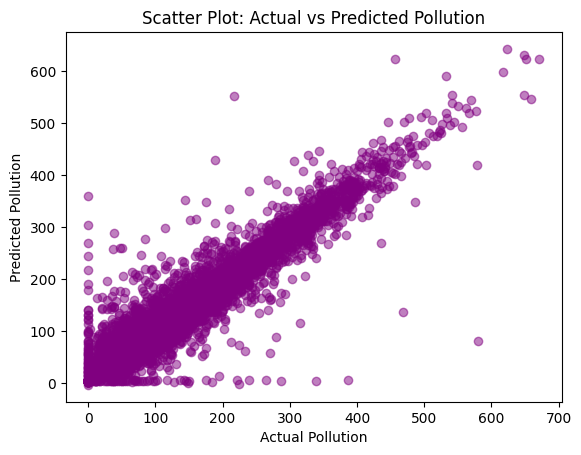

/tmp/ipykernel_7803/1282603950.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predicted"] = predictions


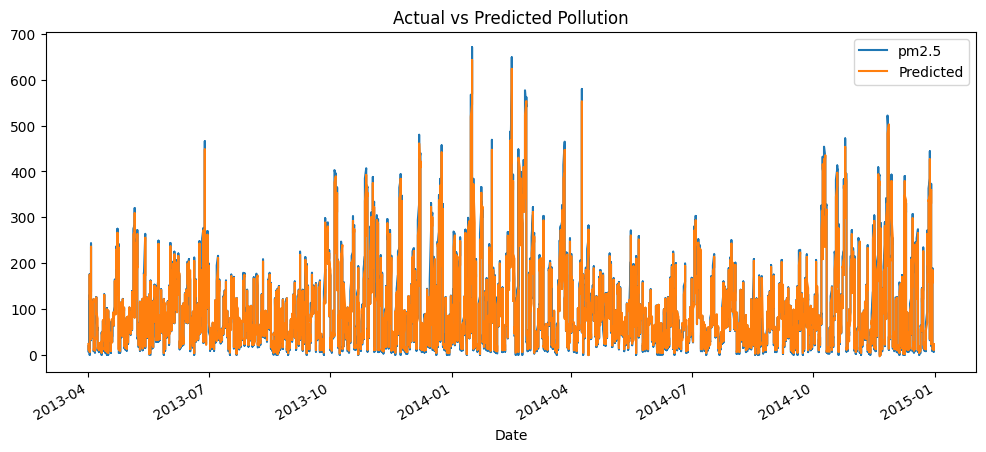

Test RMSE: 23.21
Test MAPE: 24.21%


In [4]:
# 2(a): Train-test split
train_size = int(len(df) * 0.65)
train, test = df.iloc[:train_size], df.iloc[train_size:]

### Train Autoregression model with lag=5 
lag = 5
model = AR(train["pm2.5"], lags=lag).fit()
coef = model.params
print(f"AR(5) Model Coefficients: {coef}")

### Prediction on test set
history = list(train["pm2.5"].values)
predictions = []
for t in range(len(test)):
    lag_values = history[-lag:]
    # Compute, x(t + 1) = w0 + w1 ∗ x(t) + w2 ∗ x(t−1) + ... + wp ∗ x(t−p+1). 
    yhat = coef[0] + sum(coef[i+1] * lag_values[lag-i-1] for i in range(lag))
    # Append predictions to compute RMSE later and show the predictions
    predictions.append(yhat)
    # Append actual test value to history, to be used in next step.
    history.append(test["pm2.5"].iloc[t])

# Scatter plot of actual vs predicted
plt.scatter(test["pm2.5"], predictions, alpha=0.5, color='purple')
plt.xlabel("Actual Pollution")
plt.ylabel("Predicted Pollution")
plt.title("Scatter Plot: Actual vs Predicted Pollution")
plt.show()

# Line plot of actual vs predicted
test["Predicted"] = predictions
test.plot(y=["pm2.5", "Predicted"], title="Actual vs Predicted Pollution", figsize=(12,5))
plt.show()

# Compute RMSE and MAPE
test_rmse = np.sqrt(mean_squared_error(test["pm2.5"], test["Predicted"]))
test_new = test[test["pm2.5"] != 0]
test_mape = mean_absolute_percentage_error(test_new["pm2.5"], test_new["Predicted"]) * 100
print(f"Test RMSE: {test_rmse:.2f}")
print(f"Test MAPE: {test_mape:.2f}%")
